In [ ]:
 %%capture
!pip install pandas
!pip install sklearn
!pip install tensorflow
!pip install dlomix
!pip install numpy
!pip install matplotlib
!pip install dlomix
!pip install requests

In [ ]:
# Import and normalize/standarize data
import pandas as pd
import numpy as np
# Import and normalize the data
data = pd.read_csv('https://raw.githubusercontent.com/ProteomicsML/RetentionTime/main/datasets/ProteomeTools/Small.csv')

# shuffle and split dataset into internal (80%) and external (20%) datasets
data = data.sample(frac=1)
test_data = data[int(len(data)*0.8):]
data = data[:int(len(data)*0.8)]

In [ ]:
# Split the internal dataset into training and validation
# We have to split the data based on Sequences, to make sure we dont have cross-over sequences in the training and validation splits.
unique_sequences = list(set(data['Sequence']))
# Shuffle the data to ensure unbiased data splitting
from random import shuffle
shuffle(unique_sequences)
# Split sequence 80-10-10 training, validation and testing split
train = unique_sequences[0:int(len(unique_sequences) * 0.8)]
validation = unique_sequences[int(len(unique_sequences) * 0.8):]
# Transfer the sequence split into data split
train = data[data['Sequence'].isin(train)]
validation = data[data['Sequence'].isin(validation)]
print('Training data points:', len(train),'  Validation data points:',  len(validation),'  Testing data points:',  len(test_data))
# Here we use test as an external dataset unlike the one used for training.

Training data points: 63819   Validation data points: 16181   Testing data points: 20000


In [ ]:
normalize = True
if normalize:
  # Normalize
  train_val_min, train_val_max = min(train['Retention time'].min(), validation['Retention time'].min()), max(train['Retention time'].max(), validation['Retention time'].max())
  train['Retention time'] = list((train['Retention time'] - train_val_min) / (train_val_max - train_val_min))
  validation['Retention time'] = list((validation['Retention time'] - train_val_min) / (train_val_max - train_val_min))
  test_data['Retention time'] = list((test_data['Retention time'] - test_data['Retention time'].min()) / (test_data['Retention time'].max() - test_data['Retention time'].min()))
else:
  # Standardize
  train_val_mean, train_val_std = np.mean(list(train['Retention time']) + list(validation['Retention time'])), np.std(list(train['Retention time']) + list(validation['Retention time']))
  train['Retention time'] = (train['Retention time'] - train_val_mean) / train_val_std
  validation['Retention time'] = (validation['Retention time'] - train_val_mean) / train_val_std
  test_data['Retention time'] = (test_data['Retention time'] - np.mean(test_data['Retention time'])) / np.std(test_data['Retention time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Setup parameters
sequence_length = 30
batch_size = 64
epochs=10

In [ ]:
# Setup data 
from dlomix.data import RetentionTimeDataset
train_input = RetentionTimeDataset(data_source=tuple([np.array(train['Sequence']), np.array(train['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

val_input = RetentionTimeDataset(data_source=tuple([np.array(validation['Sequence']), np.array(validation['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

test_input = RetentionTimeDataset(data_source=tuple([np.array(test_data['Sequence']), np.array(test_data['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

# Setup PROSIT model from DLOmix
from dlomix.models.prosit import PrositRetentionTimePredictor
model = PrositRetentionTimePredictor(seq_length=sequence_length)
model.build((None, sequence_length))
model.summary()

Model: "prosit_retention_time_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 string_lookup (StringLookup  multiple                 0         
 )                                                               
                                                                 
 embedding (Embedding)       multiple                  352       
                                                                 
 sequential (Sequential)     (None, 30, 512)           1996800   
                                                                 
 attention_layer (AttentionL  multiple                 542       
 ayer)                                                           
                                                                 
 sequential_1 (Sequential)   (None, 512)               262656    
                                                                 
 dense_1 (Dense)             multip

In [ ]:
from dlomix.eval.rt_eval import TimeDeltaMetric
import tensorflow as tf
# Compiling the keras model with loss function, metrics and optimizer
model.compile(loss='mse', metrics=['mae', TimeDeltaMetric()], optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
# Train the model
history = model.fit(x=train_input, epochs=epochs, batch_size=batch_size, validation_data=val_input)

Epoch 1/10
973/973 [==============================] - 38s 22ms/step - loss: 0.4840 - mae: 0.1073 - timedelta: 0.1060 - val_loss: 0.0050 - val_mae: 0.0564 - val_timedelta: 0.0596
Epoch 2/10
973/973 [==============================] - 22s 22ms/step - loss: 0.0046 - mae: 0.0475 - timedelta: 0.0486 - val_loss: 0.0029 - val_mae: 0.0347 - val_timedelta: 0.0385
Epoch 3/10
973/973 [==============================] - 20s 21ms/step - loss: 0.0039 - mae: 0.0430 - timedelta: 0.0433 - val_loss: 0.0028 - val_mae: 0.0354 - val_timedelta: 0.0380
Epoch 4/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0034 - mae: 0.0394 - timedelta: 0.0396 - val_loss: 0.0038 - val_mae: 0.0408 - val_timedelta: 0.0451
Epoch 5/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0031 - mae: 0.0372 - timedelta: 0.0373 - val_loss: 0.0025 - val_mae: 0.0324 - val_timedelta: 0.0348
Epoch 6/10
973/973 [==============================] - 22s 23ms/step - loss: 0.0029 - mae: 0.0355 - timedelta: 

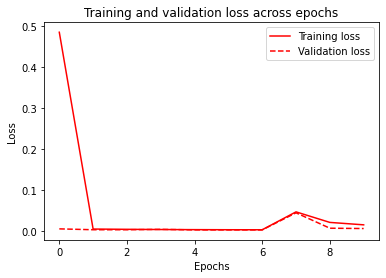

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training history 
plt.plot(range(epochs), history.history['loss'], '-', color='r', label='Training loss')
plt.plot(range(epochs), history.history['val_loss'], '--', color='r', label='Validation loss')
plt.title(f'Training and validation loss across epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0148 - mae: 0.0789 - timedelta: 0.0762
Epoch 2/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0148 - mae: 0.0767 - timedelta: 0.0743
Epoch 3/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0148 - mae: 0.0764 - timedelta: 0.0763
Epoch 4/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0148 - mae: 0.0760 - timedelta: 0.0679
Epoch 5/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0148 - mae: 0.0743 - timedelta: 0.0671
Epoch 6/10
306/306 [==============================] - 6s 20ms/step - loss: 0.0148 - mae: 0.0751 - timedelta: 0.0684
Epoch 7/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0144 - mae: 0.0730 - timedelta: 0.0710
Epoch 8/10
306/306 [==============================] - 6s 19ms/step - loss: 0.0142 - mae: 0.0728 - timedelta: 0.0654
Epoch 9/10
306/306 [==============================] - 6s 19ms/step - los

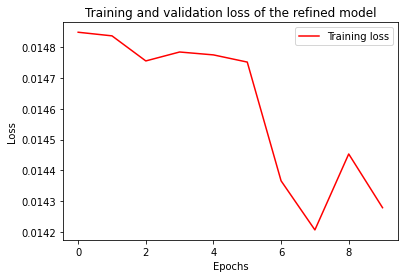

In [ ]:
# Initially we trained on just one gradient, to transfer this model to external datasets, 
# we refine the model by using the model we just trained as a pre-trained model, and then further train it with the test/external dataset
history = model.fit(x=test_input, epochs=epochs, batch_size=batch_size)
# The model can now be used for other datasets with the same gradient set-up
# We then plot the history of this model, and see the initial performance is much better, 
# as the model already has some gradient agnostic knowledge, and it simply has to learn the new gradients
plt.plot(range(epochs), history.history['loss'], '-', color='r', label='Training loss')
plt.title(f'Training and validation loss of the refined model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()